<a href="https://colab.research.google.com/github/pop756/Pasqal_chanllenge/blob/main/Mockup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import MockDevice as DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [23]:
import numpy as np
import pandas as pd
import networkx as nx
diagonal = -20

def generate_distance_weighted_Q_matrix_with_soft_constraint(size=7, diagonal=-10, max_edges=4, penalty_term=5.0, hamming_weight=3, seed=42):
    """
    각 노드가 최대 max_edges 개의 엣지를 가지면서, 거리가 멀어질수록 가중치가 작아지는 Q 행렬을 생성.
    또한, 특정 개수만 선택되도록 하는 soft constraint를 추가.
    :param size: 생성할 행렬의 크기 (size x size)
    :param diagonal: 대각 원소 값
    :param max_edges: 각 노드가 가질 수 있는 최대 엣지 개수
    :param penalty_term: Hamming weight 제약을 위한 패널티 값
    :param hamming_weight: 선택해야 하는 노드 개수
    :param seed: 랜덤 시드 값 (재현 가능성 유지)
    :return: 거리 기반 가중치를 가지는 Q 행렬 (numpy array), 그래프, 노드 좌표
    """
    np.random.seed(seed)

    # 노드의 랜덤한 2D 좌표 생성
    coordinates = np.random.rand(size, 2) * 10  # 10x10 범위 내에서 랜덤 좌표
    print("original coordinate")
    # 노드 간 거리 계산
    distances = pdist(coordinates)  # 1D 배열 형태의 거리 정보
    distance_matrix = squareform(distances)  # 2D 대칭 행렬로 변환

    # 가중치는 거리의 역수의 제곱으로 설정 (거리가 멀어질수록 값이 작아짐)
    weights = 1 / (distance_matrix + np.eye(size))**2  # 자기 자신과의 거리는 제외
    print( weights)
    # 그래프를 생성하여 각 노드의 연결을 제한
    G = nx.Graph()
    for i in range(size):
        G.add_node(i, pos=coordinates[i])  # 노드 좌표 저장

    # 가장 가까운 max_edges 개의 노드만 연결
    edges = []
    for i in range(size):
        closest_nodes = np.argsort(distance_matrix[i])  # 거리 기준으로 정렬
        connected = 0

        for j in closest_nodes:
            if i == j or connected >= max_edges or G.degree[j] >= max_edges:
                continue

            if (i, j) not in edges and (j, i) not in edges and weights[i, j] > 0:  # 0이 아닌 경우만 추가
                edges.append((i, j))
                G.add_edge(i, j, weight=weights[i, j])  # 가중치 추가
                connected += 1

    # Q 행렬 초기화
    Q = np.zeros((size, size))

    # 그래프의 엣지를 기반으로 Q 행렬 채우기
    for i, j in edges:
        Q[i, j] = weights[i, j] * 50
        Q[j, i] = weights[j, i] * 50  # 대칭성 유지

    # 대각 성분 설정
    np.fill_diagonal(Q, diagonal)

    # Soft Constraint 추가 (Hamming weight 제약)
    for i in range(size):
        Q[i, i] += penalty_term * (1 - 2 * hamming_weight)  # Hamming weight 페널티 적용
        for j in range(i + 1, size):
            Q[i, j] +=  penalty_term
            Q[j, i] +=  penalty_term  # 대칭성 유지

    return Q/10, G, coordinates


# 12x12 Q 행렬 생성 (Soft Constraint 포함)
Q, G, coordinates = generate_distance_weighted_Q_matrix_with_soft_constraint(
    size=6, diagonal=-10, penalty_term=290.0, hamming_weight=2
)


original coordinate
[[1.         0.03972723 0.01472036 0.0932041  0.09073489 0.07958422]
 [0.03972723 1.         0.0189502  0.0190215  0.34363389 0.01552961]
 [0.01472036 0.0189502  1.         0.01945718 0.01988463 0.01468859]
 [0.0932041  0.0190215  0.01945718 1.         0.03126174 0.82190436]
 [0.09073489 0.34363389 0.01988463 0.03126174 1.         0.02465639]
 [0.07958422 0.01552961 0.01468859 0.82190436 0.02465639 1.        ]]


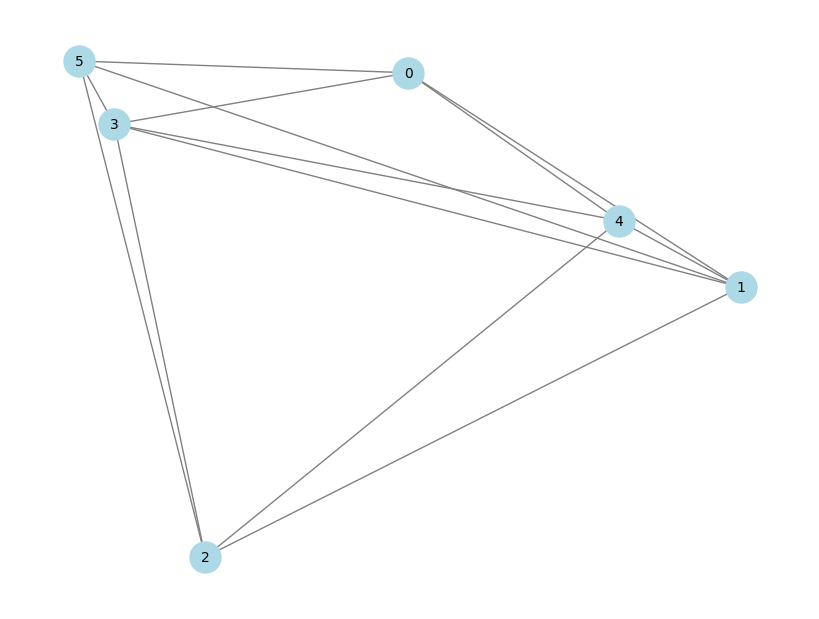

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
# 노드의 위치를 가져옵니다.
pos = nx.get_node_attributes(G, 'pos')

# 그래프를 그립니다.
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.show()

In [182]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6)
    Q_copy = np.array(Q)
    np.fill_diagonal(Q_copy, 0)
    print(np.sum(abs(new_Q - Q_copy)))
    return np.sum(abs(new_Q - Q_copy))


def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6)
    Q_copy = np.array(Q)
    np.fill_diagonal(Q_copy, 0)
    cost = np.linalg.norm(new_Q - Q_copy)
    return cost


def evaluate_mapping_penalized(new_coords, Q, alpha=0.1):
    """
    Cost function with penalty to prevent large variance in entity distances.

    alpha: penalty coefficient (higher = stronger enforcement of similar distances)
    """
    new_coords = np.reshape(new_coords, (len(Q), 2))
    new_Q = squareform(DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6)

    Q_copy = np.array(Q)
    np.fill_diagonal(Q_copy, 0)

    # 기본 Cost: Q 행렬과의 차이 최소화
    base_cost = np.linalg.norm(new_Q - Q_copy)

    # 🔹 추가 Penalty: 같은 값(예: 11 또는 35)끼리 거리 차이가 너무 크지 않도록 함
    unique_values = np.unique(Q)  # Q에서 고유한 값 찾기
    penalty = 0

    for val in unique_values:
        indices = np.where(Q == val)  # 같은 값을 가진 인덱스 찾기
        if len(indices[0]) > 1:  # 그룹 내 2개 이상 존재할 때만 계산
            subset = new_coords[indices]  # 해당 값의 좌표들
            distances = pdist(subset)  # 그룹 내 거리 계산
            variance = np.var(distances)  # 거리 차이의 분산
            penalty += variance  # 전체 패널티에 추가

    total_cost = base_cost + alpha * penalty
    print(
        f"Base Cost: {base_cost:.4f}, Penalty: {penalty:.4f}, Total Cost: {total_cost:.4f}"
    )

    return total_cost

In [180]:
def evaluate_mapping_Q(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    Q_copy = np.array(Q)
    np.fill_diagonal(new_Q, Q[0][0])
    return new_Q

In [183]:
costs = []
np.random.seed(25)
# 초기 좌표를 정N각형의 형태로 배치
angles = np.linspace(0, 2 * np.pi, Q.shape[0], endpoint=False)
initial_positions = np.column_stack(( np.cos(angles),  np.sin(angles)))*5
initial_positions = np.reshape(initial_positions,-1)
# res = minimize(
#     evaluate_mapping,
#     initial_positions,
#     args=(Q,),
#     method="COBYLA",
#     tol=1e-6,
#     options={"maxiter": 500, "maxfev": None},
# )
res = minimize(
    evaluate_mapping,
    initial_positions,
    args=(Q,),
    method="SLSQP"
)
methods = ["COBYLA", "SLSQP", "trust-constr", "L-BFGS-B"]

for method in methods:
    result = minimize(evaluate_mapping_penalized, initial_positions ,args=(Q,), method=method)
    print(f"Method {method}: Optimal cost = {result.fun}")
coords = np.reshape(res.x, (len(Q), 2))
Q_cord = evaluate_mapping_Q(coords, Q)

IndexError: index 2 is out of bounds for axis 1 with size 2

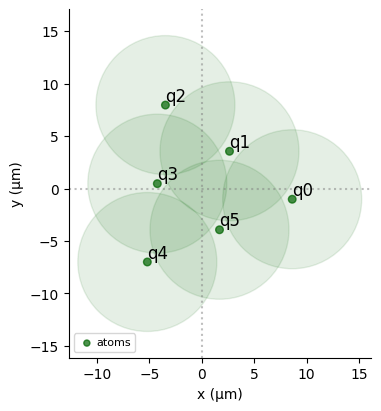

In [175]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [150]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:6])

[('000011', -118.0), ('101000', -118.0), ('001001', -117.85311410767761), ('010001', -117.84470385325423), ('011000', -117.81049800595463), ('010100', -117.8097849771617)]


In [151]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q_cord @ z
    costs.append(cost)
zipped_cord = zip(bitstrings, costs)
sort_zipped_cord = sorted(zipped_cord, key=lambda x: x[1])
print(sort_zipped_cord[:6])

[('101010', -261.21071980081837), ('111010', -228.22519826465455), ('101110', -228.0753817947936), ('101011', -227.77684485581557), ('011010', -201.6379367891911), ('001011', -201.63767428287588)]


In [152]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = Q[0][0]  # just has to be negative
delta_f = -Q[0][0]  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

In [153]:
from pulser import Pulse, Sequence
from pulser.waveforms import RampWaveform

def apply_detuning_to_global_pulse(global_pulse, detuning_list, qubits):
    """
    기존 global pulser를 받아서 각 큐비트에 개별 detuning을 적용하는 함수.

    :param global_pulse: 기존 global하게 적용되는 Pulser Pulse 객체
    :param detuning_list: 각 큐비트에 적용할 detuning 값 리스트
    :param qubits: 큐비트 리스트 (sequence에서 사용할 register)
    :return: 새로운 Pulser Sequence 객체
    """
    # 새로운 시퀀스 생성
    seq = Sequence(register=qubits)

    # 원래 global pulse의 duration 가져오기
    duration = global_pulse.duration

    for i, detuning in enumerate(detuning_list):
        # 새로운 detuning 값을 적용한 waveform 생성 (RampWaveform 활용)
        detuning_waveform = RampWaveform(duration, global_pulse.detuning.amplitude, detuning)

        # 새로운 Pulse 생성 (Rabi frequency와 phase는 기존과 동일, detuning만 변경)
        new_pulse = Pulse(
            amplitude=global_pulse.amplitude,
            detuning=detuning_waveform,
            phase=global_pulse.phase,
            duration=duration
        )

        # 특정 큐비트에 적용
        seq.add(new_pulse, qubits[i])

    return seq


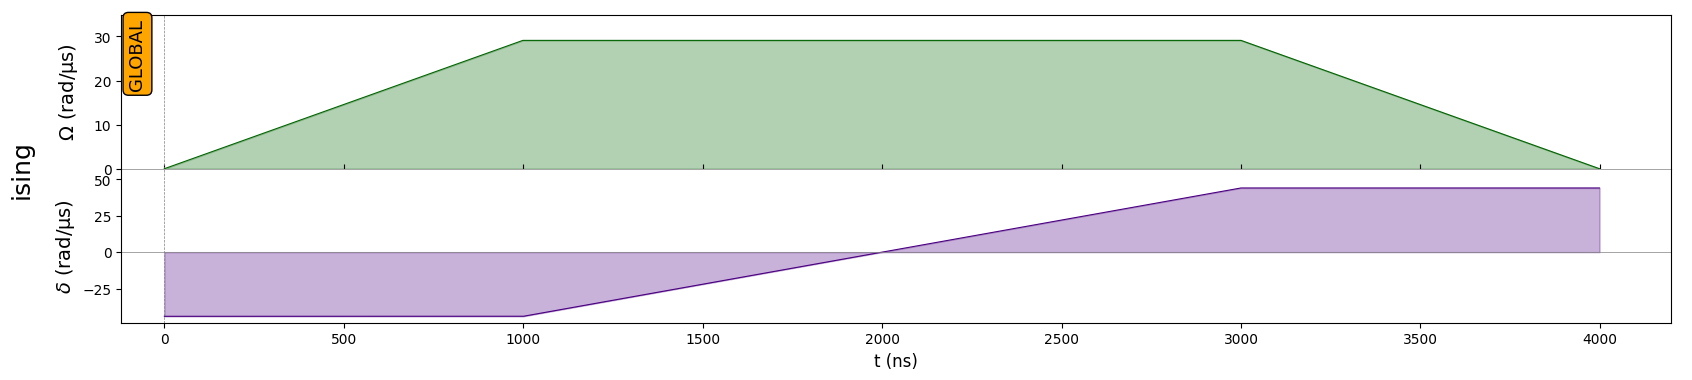

' seq_2 = Sequence(reg, DigitalAnalogDevice)\nseq_2.declare_channel("ising", "rydberg_global")\nseq_2.add(adiabatic_pulse_2, "ising") '

In [154]:
import pulser
adiabatic_pulse_list = [Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [Q[i][i]/2, 0, -Q[i][i]/2]),
    0,
) for i in range(len(Q))]

adiabatic_pulse_2 = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0/2, 0, delta_f/2]),
    0,
)


seq_1 = Sequence(reg, DigitalAnalogDevice)
#seq_1.declare_channel("ising", "rydberg_global")


for i in range(len(adiabatic_pulse_list)):

  seq_1.declare_channel(f"ch{i}", "rydberg_local")
  seq_1.target(f"q{i}", f"ch{i}")
  seq_1.add(adiabatic_pulse_list[i], f"ch{i}")




rise = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(T/4, 0.0, Omega), delta_0/2, 0.0
)
sweep = pulser.Pulse.ConstantAmplitude(
    Omega, pulser.RampWaveform(T*2/4, delta_0/2, delta_f/2), 0.0
)
fall = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(T/4 , Omega, 0.0), delta_f/2, 0.0
)

seq_2 = Sequence(reg, DigitalAnalogDevice)
seq_2.declare_channel("ising", "rydberg_global")
seq_2.add(rise, "ising")
seq_2.add(sweep, "ising")
seq_2.add(fall, "ising")
seq_2.draw(mode="input")


''' seq_2 = Sequence(reg, DigitalAnalogDevice)
seq_2.declare_channel("ising", "rydberg_global")
seq_2.add(adiabatic_pulse_2, "ising") '''


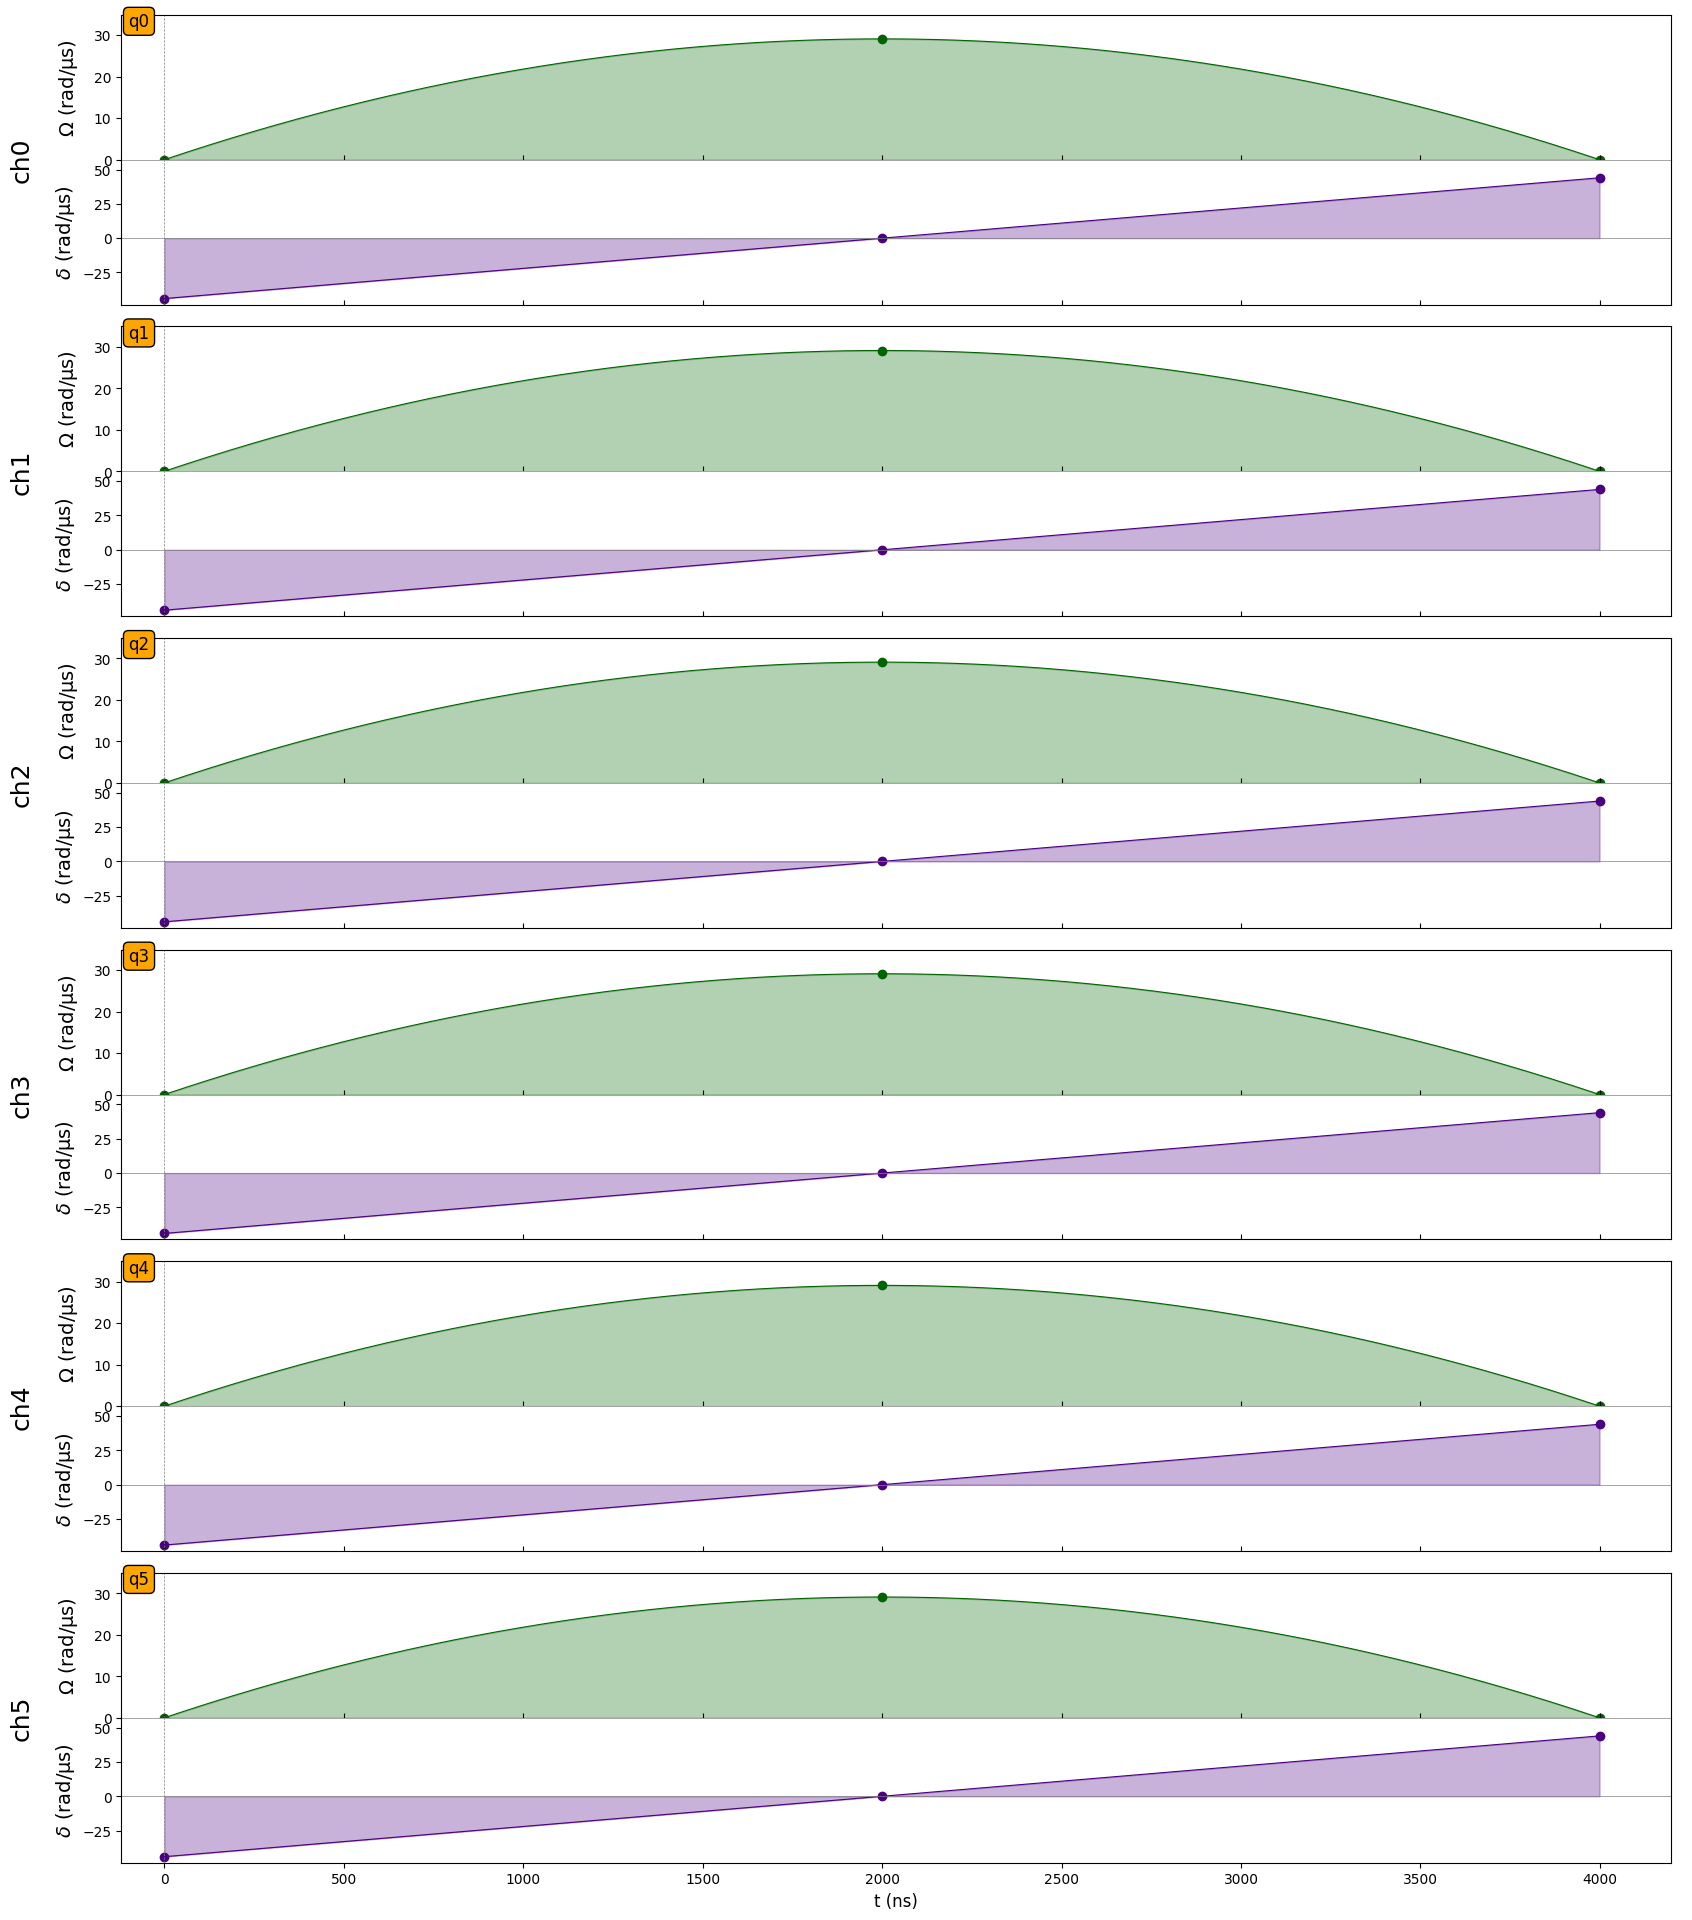

In [155]:
seq_1.draw()

In [156]:
simul_1 = QutipEmulator.from_sequence(seq_1)
results_1 = simul_1.run()
final_1 = results_1.get_final_state()
count_dict_1 = results_1.sample_final_state()

In [157]:

simul_2 = QutipEmulator.from_sequence(seq_2)
results_2 = simul_2.run()
final_2 = results_2.get_final_state()
count_dict_2 = results_2.sample_final_state()

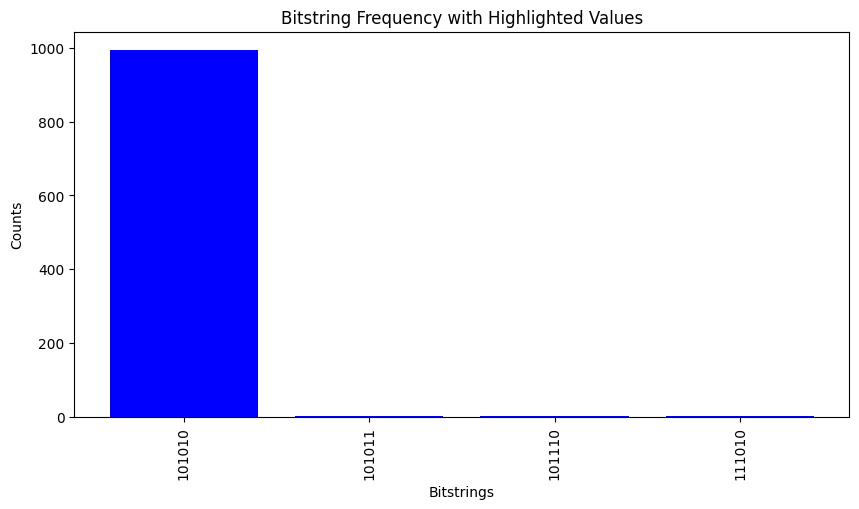

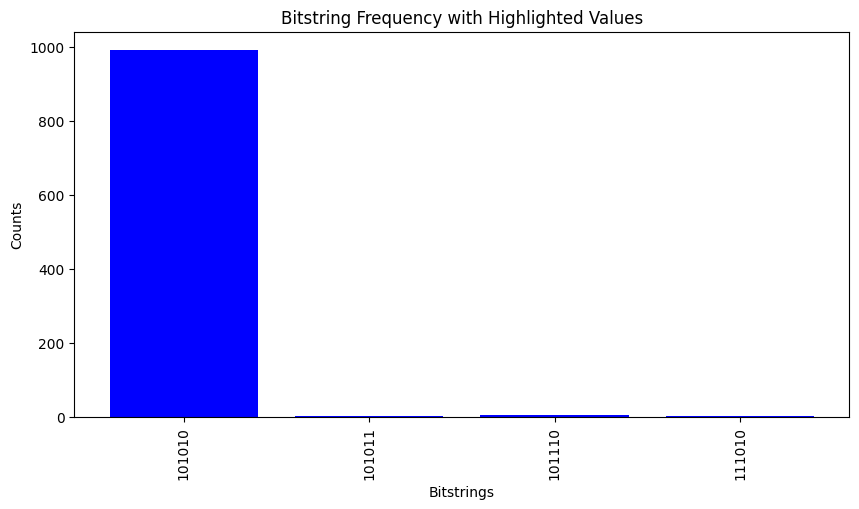

In [158]:
import matplotlib.pyplot as plt
from collections import Counter
def plot_bitstring_counts(input_data, bitstring_counts):
    """
    입력된 bitstring 목록을 기반으로 주어진 bitstring_counts에서 해당 bitstring을
    빨간색 막대로 강조하고, 나머지는 파란색으로 표시하는 그래프를 생성합니다.

    :param input_data: List of tuples (bitstring, value)
    :param bitstring_counts: Dictionary (bitstring -> count)
    """
    import matplotlib.pyplot as plt

    # 빨간색으로 강조할 bitstring 목록 추출
    highlighted_strings = {bitstring for bitstring, _ in input_data}

    # 데이터 준비
    bitstrings = list(bitstring_counts.keys())
    counts = list(bitstring_counts.values())
    colors = ['red' if bitstring in highlighted_strings else 'blue' for bitstring in bitstrings]

    # 막대 그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(bitstrings, counts, color=colors)
    plt.xlabel("Bitstrings")
    plt.ylabel("Counts")
    plt.title("Bitstring Frequency with Highlighted Values")
    plt.xticks(rotation=90)
    plt.show()



plot_bitstring_counts(sort_zipped[:2], count_dict_1)
plot_bitstring_counts(sort_zipped[:2], count_dict_2)

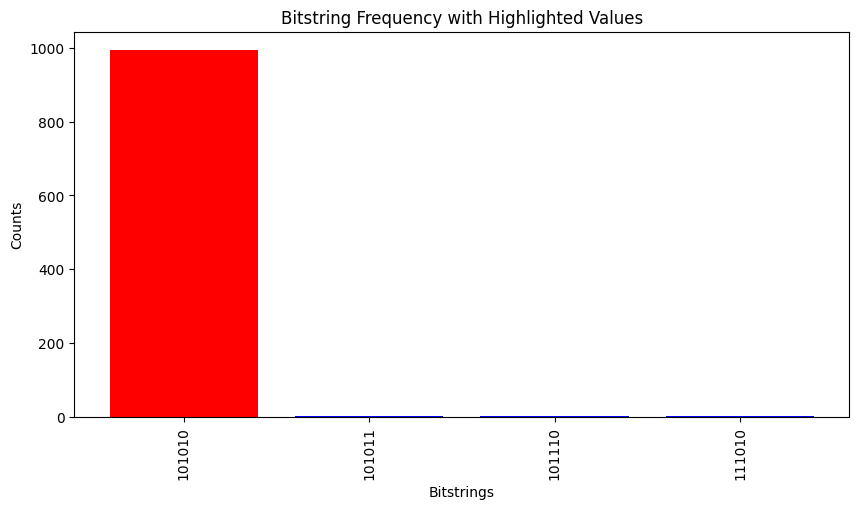

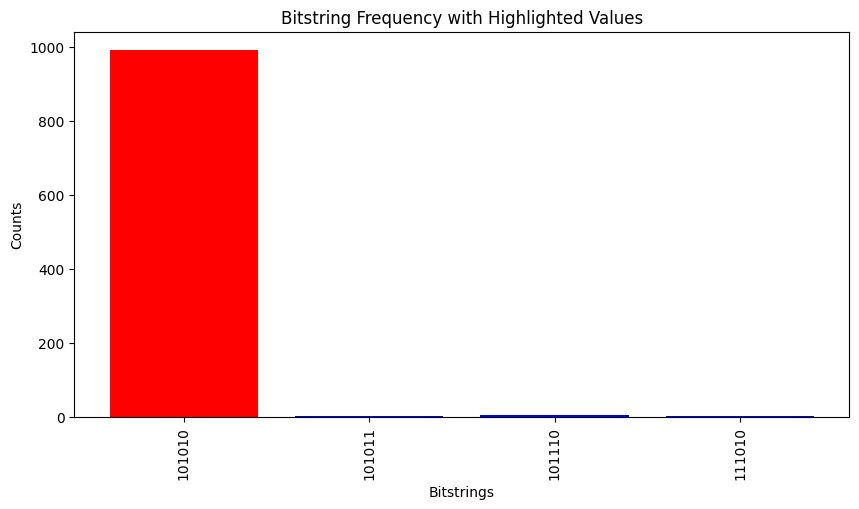

In [159]:

import matplotlib.pyplot as plt
from collections import Counter
def plot_bitstring_counts(input_data, bitstring_counts):
    """
    입력된 bitstring 목록을 기반으로 주어진 bitstring_counts에서 해당 bitstring을
    빨간색 막대로 강조하고, 나머지는 파란색으로 표시하는 그래프를 생성합니다.

    :param input_data: List of tuples (bitstring, value)
    :param bitstring_counts: Dictionary (bitstring -> count)
    """
    import matplotlib.pyplot as plt

    # 빨간색으로 강조할 bitstring 목록 추출
    highlighted_strings = {bitstring for bitstring, _ in input_data}

    # 데이터 준비
    bitstrings = list(bitstring_counts.keys())
    counts = list(bitstring_counts.values())
    colors = ['red' if bitstring in highlighted_strings else 'blue' for bitstring in bitstrings]

    # 막대 그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(bitstrings, counts, color=colors)
    plt.xlabel("Bitstrings")
    plt.ylabel("Counts")
    plt.title("Bitstring Frequency with Highlighted Values")
    plt.xticks(rotation=90)
    plt.show()



plot_bitstring_counts(sort_zipped_cord[:1], count_dict_1)
plot_bitstring_counts(sort_zipped_cord[:1], count_dict_2)